# Creating your own classifier
## Introduction

This is just a really simple tutorial in creating your own classifier, there are a multitude of classifiers out there all with their own intrticacies and pros and cons, everything depends on the data you use to train the classifiers as to which one to choose. Remember your classifier can only be as good as the data you train on.

Before even starting to classify make sure you have a clean, rich, informative dataset with sensible features and plenty of training examples which are representative of the data which you want to classify in the end. As with all machine learning algorithms, junk goes and junk goes out....


*What do I need to create my own classifier?*

* Lots of data with truth information, that is a label which indicates which class the samples should actually be defined as.

* A good composition of samples: A similar number of samples for each category which you desire to classify (such that you have a representative number of samples from which to construct the classifier from)

* Someone happy to read an implement python code and whom understands the data and its biases.

# Starting Point : Know your data

The beginnings of all data analysis journeys commence with looking at your data, understanding its strength and weaknesses and making sense of it.

Read in your data.

For this toy example we will use the classic iris dataset.

In [1]:
#Read in libraries
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import pandas as pd
import math
from sklearn.cross_validation import train_test_split
import seaborn as sns

#Different Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

#Different Metrics/Plots
from sklearn.decomposition import PCA
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc

#Iris dataset
from sklearn.datasets import load_iris

#For jupyter notebook to display figures
from matplotlib import patches
%matplotlib inline

In [2]:
#Read in the data
iris = load_iris()
idf = pd.DataFrame(iris.data,columns=['Sepal Length','Sepal Width','Petal Length','Petal Width'])
idf.head()


,Sepal Length,Sepal Width,Petal Length,Petal Width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [3]:
#Lets normalise the data such that every feature has max 0 and min 1 so they are more comparable
idf = idf.div(idf.max(axis=0),axis=1)

In [4]:
#Get the target info
targets = pd.DataFrame(iris.target,columns=['Class'])
targets.head()

,Class
0,0
1,0
2,0
3,0
4,0


In [5]:
#Now lets view what our data looks like in a PCA plot
transformed_counts = PCA(n_components=2).fit_transform(idf)


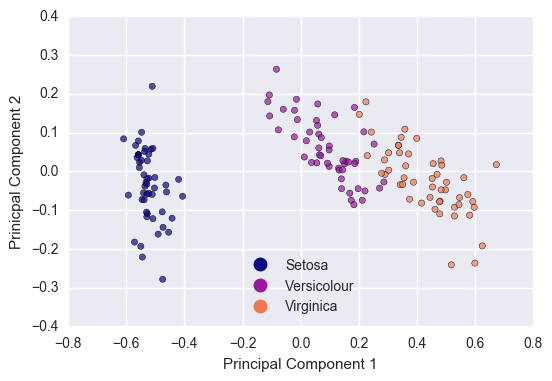

In [6]:
#Lets plot it!
#Get a color for each Class
cmap = plt.get_cmap('plasma')

def get_n_colors(n):
    return[ cmap(float(i)/n) for i in range(n)]

colors = get_n_colors(len(targets.Class.unique()))


#Make color dictionary
col_dict = {}     
for g in targets.Class.unique():
    col = colors[g]
    col = list(col)
    col[3] = 0.7 #Change alpha
    col_dict[g] = col

plt.scatter(transformed_counts[:,0],transformed_counts[:,1],c=targets.Class.apply(lambda x: col_dict[x]))

#Make custom handles for legend
circles = [Line2D(range(1),range(1),color='none',marker='o',markersize=10,markerfacecolor=col) for col in colors]
plt.legend( circles,['Setosa','Versicolour','Virginica'],loc='lower center')

plt.xlabel('Principal Component 1')
plt.ylabel('Prinicpal Component 2')

So clearly group the three different classes seperate out well, however Versicolour and Virginica are more similar to each other.

# Train Building

In this particular case we only have four different features from which to distinguish the 3 classes with, so we dont need to do any feature selection as we might normally do. So we can split our dataset up into a training dataset and a test dataset, for this example we select a random 80% of the samples to train our classifier on and 20% from which to test.

In [7]:
#Shuffle and split training and test datasets
random_state= np.random.RandomState(0)
y=label_binarize(targets.Class,classes=targets.Class.unique())
X_train,X_test,y_train, y_test = train_test_split(idf,y,test_size=0.2,random_state=random_state)

In [8]:
#Learn to predict each class against the other
classifier = OneVsRestClassifier(LinearSVC(C=1))

y_score = classifier.fit(X_train,y_train).decision_function(X_test)

#Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(y.shape[1]):
    fpr[i],tpr[i], _ = roc_curve(y_test[:,i],y_score[:,i])
    roc_auc[i] = auc(fpr[i],tpr[i])


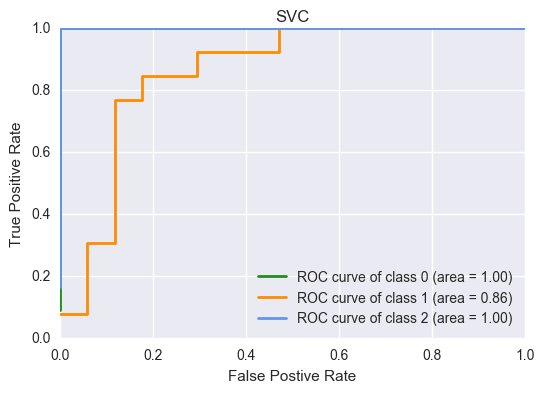

In [9]:
plt.figure()
colors = ['forestgreen','darkorange','cornflowerblue']

for i, color in zip(range(4),colors):
    plt.plot(fpr[i],tpr[i],color=color,lw=2,label = 'ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.legend(loc="lower right")
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVC')

# Compare multiple calssification methods

In the above methodology we consider just one possible machine learning algorithm for classification, but with pythons scipy package we can easily just implement a whole host of different classification methods very quickly and view the ROC curve for different classes, lets implement this as a function.

In [10]:
#Lets define a function to classify the data with a given classifier

def class_and_plot(classifier,X_test,X_train,y_test,y_train,name):
    
    #Fit the classifier to the test data and train on the test data
    if(name != 'Random Forest'): 
        y_score = classifier.fit(X_train,y_train).decision_function(X_test)
    else: 
        y_score = classifier.fit(X_train,y_train).predict(X_test)
        
    #Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(y_test.shape[1]):
        fpr[i],tpr[i], _ = roc_curve(y_test[:,i],y_score[:,i])
        roc_auc[i] = auc(fpr[i],tpr[i])
        
    #Now plot
    plt.figure()
    colors = ['forestgreen','darkorange','cornflowerblue']

    for i, color in zip(range(4),colors):
        plt.plot(fpr[i],tpr[i],color=color,lw=2,label = 'ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    plt.legend(loc="lower right")
    plt.xlabel('False Postive Rate')
    plt.ylabel('True Positive Rate')
    plt.ylim((0,1))
    plt.title(name)
    
        

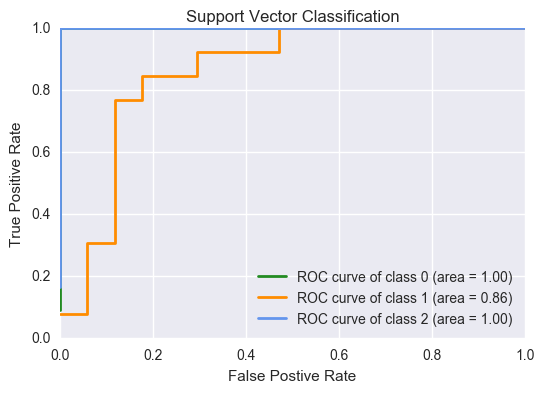

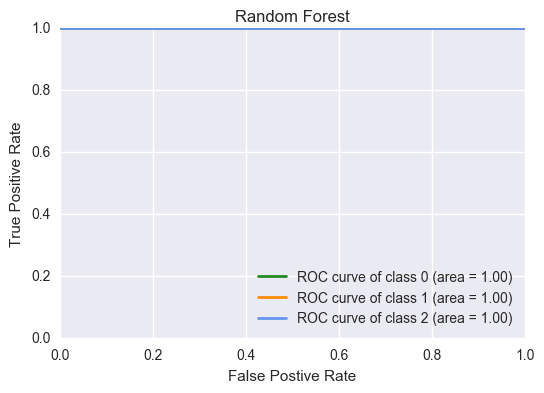

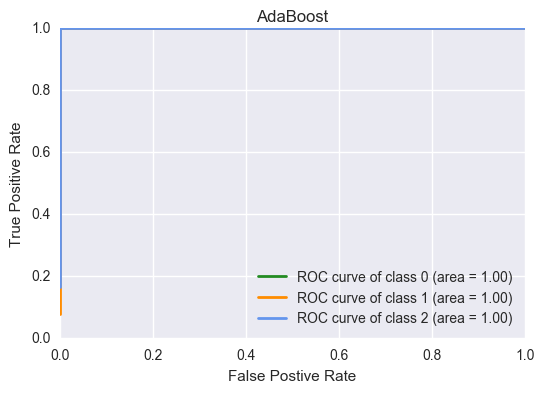

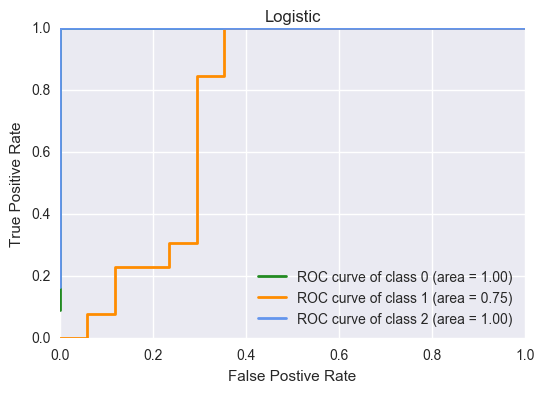

In [11]:
#Make a list containing all the classifiers you want to consider with the standard setup, note: for any specific 
#classifier you will want to refine and tweak the hyperparameters, however the defaults usually produce decent results
classifiers = [
    LinearSVC(C=1),
    RandomForestClassifier(n_estimators=501,),
    AdaBoostClassifier(),
    LogisticRegression()]

#Classifier names
cnames = ['Support Vector Classification','Random Forest', 'AdaBoost', 'Logistic']

for i,classifier in enumerate(classifiers):
    class_and_plot(OneVsRestClassifier(classifier),X_test,X_train,y_test,y_train,cnames[i])

# Choosing a classifer

Sometimes the choose of a classifier isnt simply down to which one performs best, but also whether the classification can result into meaningful results. In this simple toy dataset all four classifiers get near 100% accuracy and with the correct tuning of hyperparameters are more or less the same. However, with the random forest one can also recover the importance of the different genes used in creating the classifier which can be helpful when trying to gain some biological insight.

## But which genes are important?

So lets construct the random forest classifier and extract the important genes.





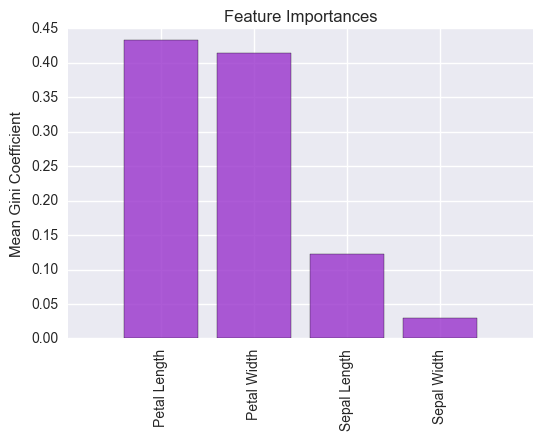

In [12]:
#Construct random forest
classifier = RandomForestClassifier(n_estimators=501)
forest = classifier.fit(X_train,y_train)

#Extract important features
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = idf.columns.values[indices]
#Plot
plt.figure()
plt.title("Feature Importances")
plt.bar(range(4),importances[indices],align="center",color="darkorchid",alpha=0.8)
plt.ylabel('Mean Gini Coefficient')
plt.xticks(range(4), feature_names, rotation='vertical')
plt.xlim(-1,4)
plt.show()


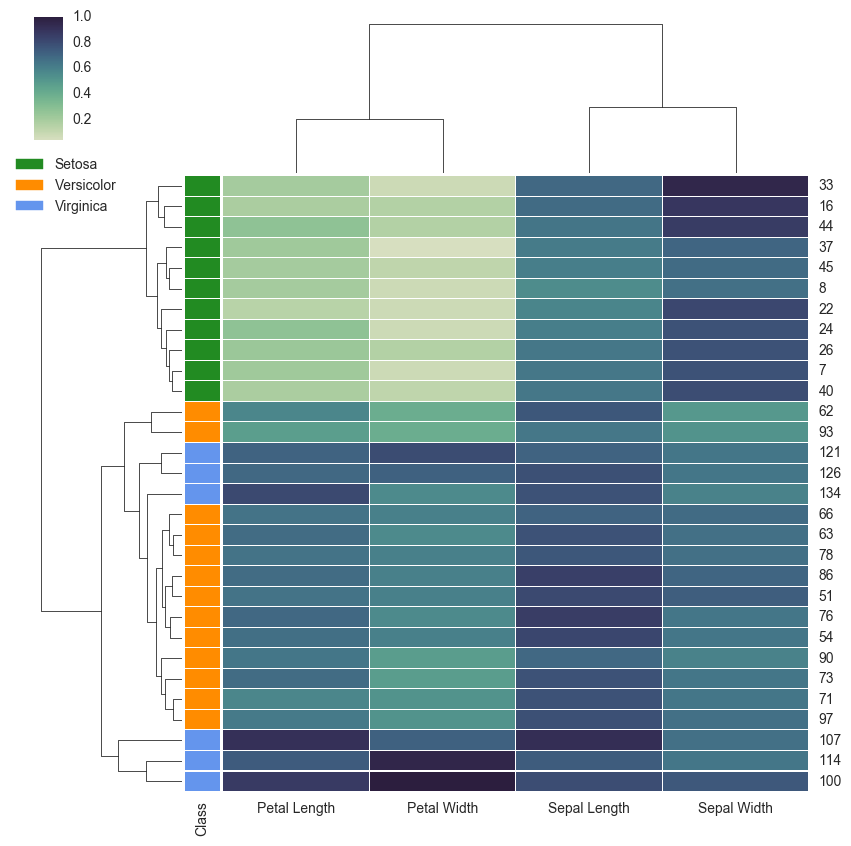

In [13]:
#Well lets make a hierarchical clustering of the features in the datasets

#Now uses sns hiearchical cluster map

# Create a custom colormap for the heatmap values
cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)


#Convert classifer array to string
ttl = []
for arr in y_test:
    if(arr[0] == 1): 
        ttl.append('Setosa')
    elif(arr[1]==1):
        ttl.append('Versicolour')
    else:
        ttl.append('Virginica')
        
class_pal = ['forestgreen','darkorange','cornflowerblue']       
class_dict = dict(zip(map(str, ['Setosa','Versicolour','Virginica']), class_pal))

# Convert the palette to vectors that will be drawn on the side of the matrix

sample_colors = pd.Series(ttl, index=X_test.index.values,name="Class").map(class_dict)

cg = sns.clustermap(X_test, cmap=cmap ,linewidth=.01, row_colors=sample_colors)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

# Create the legend patches
legend_patches = [patches.Patch(color=C) for C in class_pal]
plt.legend(legend_patches,['Setosa','Versicolor','Virginica'],bbox_to_anchor=(3, -0.1), borderaxespad=0.)
plt.show()

# Lets explore the distributions with Seaborn
## Hexbin plot with marginal distributions

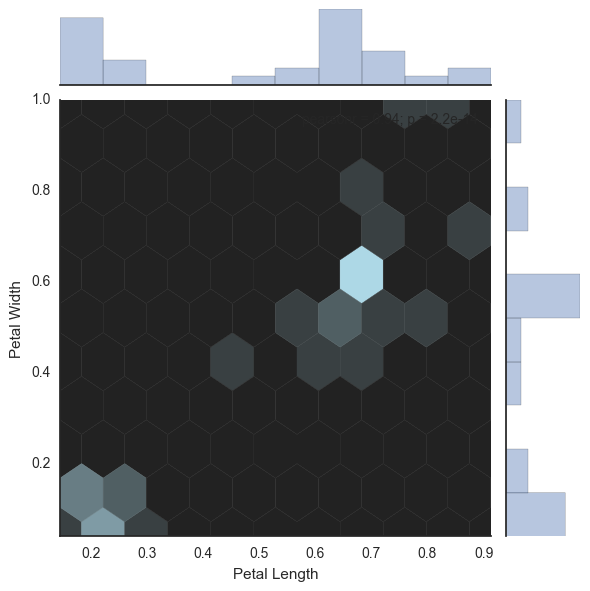

In [14]:
sns.set_style("white")
pal = sns.dark_palette("lightblue", as_cmap=True)
sns.jointplot(X_test['Petal Length'],X_test['Petal Width'], kind="hex",gridsize=10,cmap=pal, marginal_kws=dict(bins=10))

# Scatterplot Matrix

/Users/anthony/anaconda/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


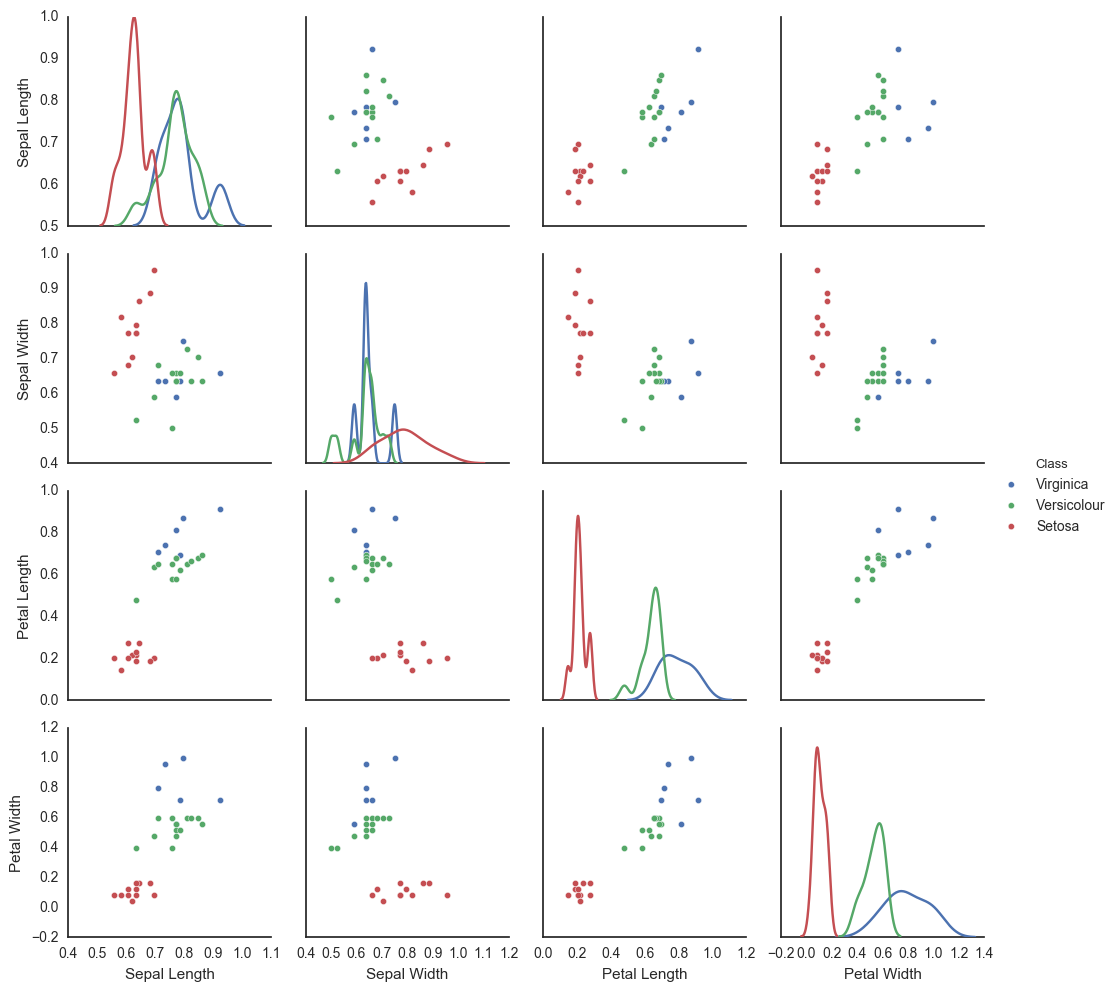

In [15]:
combo = X_test.reset_index(drop=True)
combo['Class'] = ttl
combo.head()
sns.pairplot(combo.iloc[:,[0,1,2,3,4]], hue="Class",diag_kind="kde")

# KDE PairGrid

/Users/anthony/anaconda/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/anthony/anaconda/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


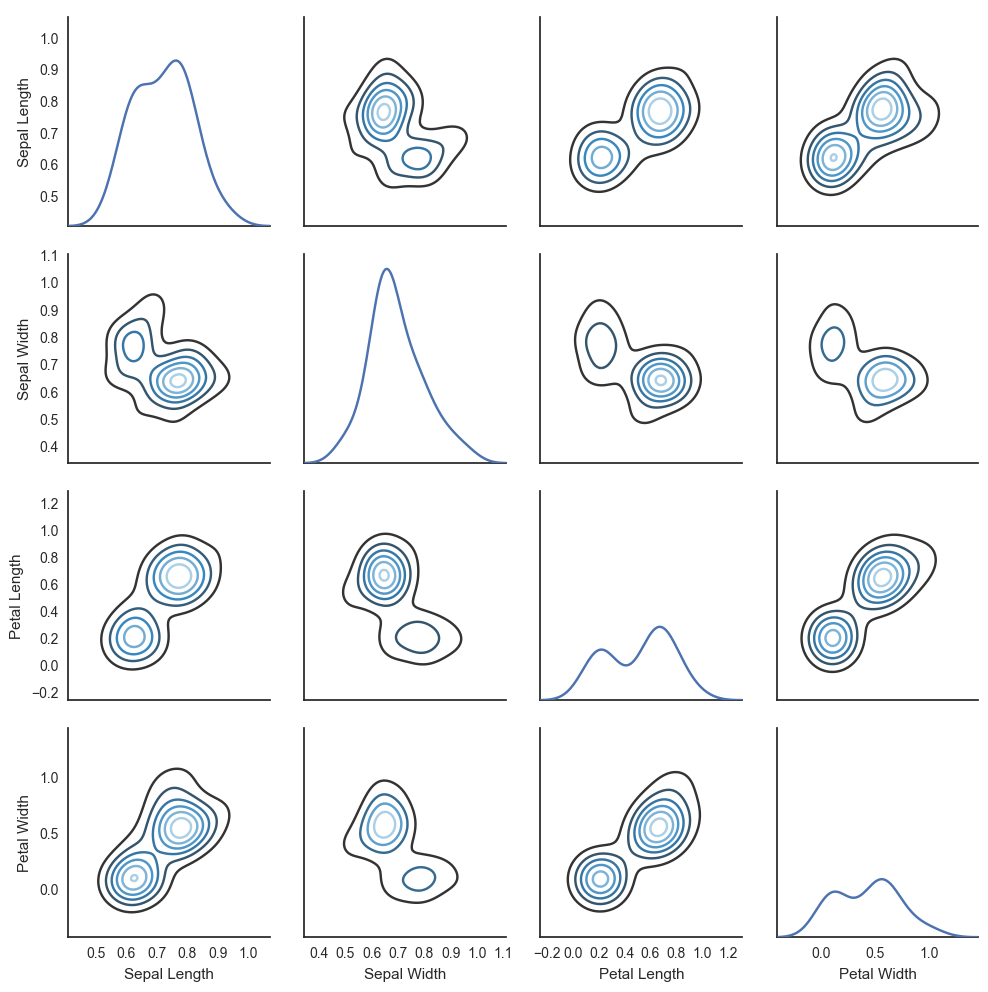

In [16]:
g = sns.PairGrid(X_test)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot,cmap="Blues_d", n_levels=6);

# Correlation

But how correlated are the four variables?

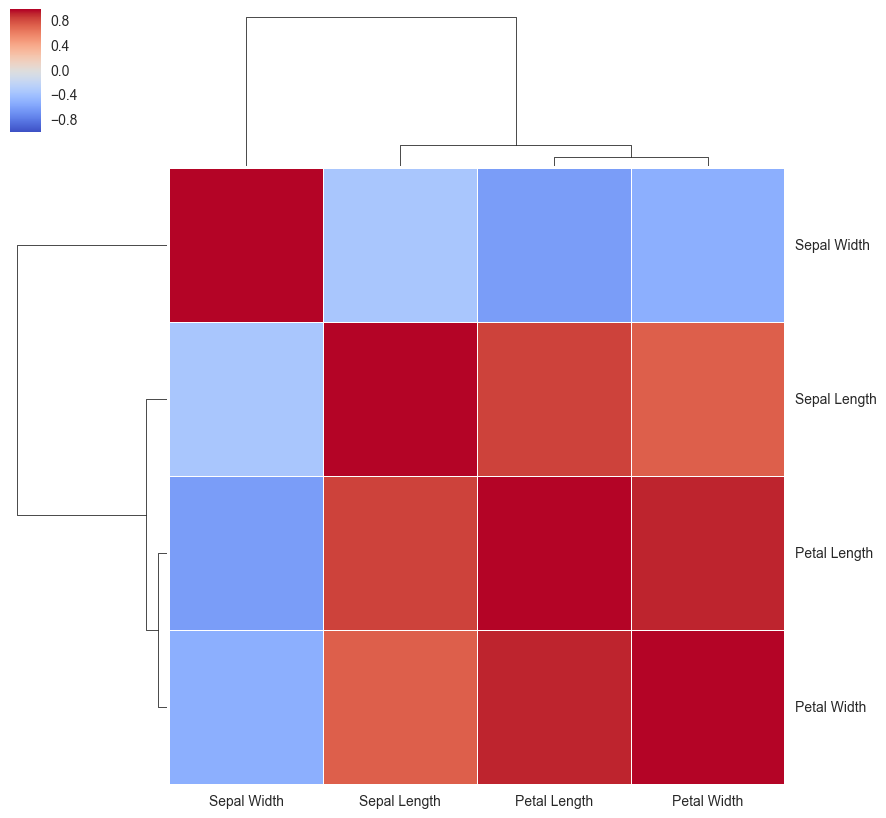

In [17]:
corrmat = X_test.corr()
cg=sns.clustermap(corrmat, cmap="coolwarm" ,linewidth=.01)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

# Clustering

Well lets say we didn't have any labelling for the true class, could we ascertain the grouping by an unsupervised clustering?

In [18]:

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler


## K-means

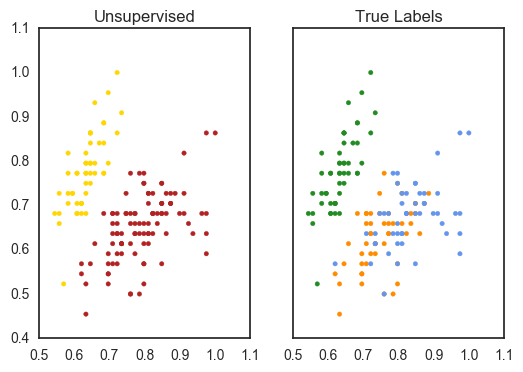

In [28]:
tc = np.array(idf)

#Estimate bandwith for mean shift
bandwidth = cluster.estimate_bandwidth(tc,quantile=0.3)
    
#Creat clustering
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(tc)

#Get labels
y_pred = ms.labels_.astype(np.int)
colors = np.array(['forestgreen','darkorange','cornflowerblue']) 
colorsp = np.array(['firebrick','gold','midnightblue'])
        
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(tc[:, 0], tc[:, 1],color=colorsp[y_pred],s=10)
ax1.set_title('Unsupervised')
ax2.scatter(tc[:, 0], tc[:, 1],color=colors[targets['Class']],s=10)
ax2.set_title('True Labels')

So as you can see above, a k means unsupervised clustering might only find two clusters naturally...

# Agglomerative Clustering

/Users/anthony/anaconda/anaconda/lib/python3.5/site-packages/sklearn/cluster/hierarchical.py:443: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)


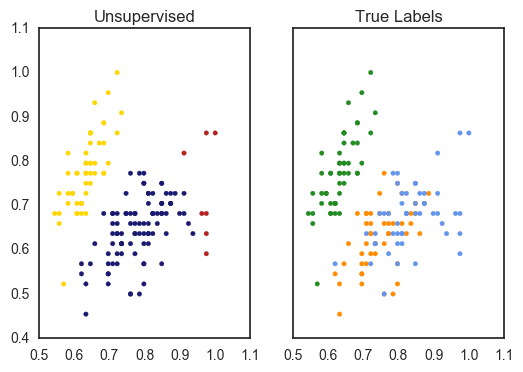

In [29]:
# connectivity matrix for structured Ward
connectivity = kneighbors_graph(tc, n_neighbors=10, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=3,
        connectivity=connectivity)
average_linkage.fit(tc)
#Get labels
y_pred2 = average_linkage.labels_.astype(np.int)
colors = np.array(['forestgreen','darkorange','cornflowerblue'])       
colorsp = np.array(['firebrick','gold','midnightblue'])

#Plot
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(tc[:, 0], tc[:, 1],color=colorsp[y_pred2],s=10)
ax1.set_title('Unsupervised')
ax2.scatter(tc[:, 0], tc[:, 1],color=colors[targets['Class']],s=10)
ax2.set_title('True Labels')

# Cluster metrics

There are many ways to measure how well a clustering algorithm has successfully clustered. Obviously if you have the truth information (which we do) we can get better metrics, however more often than not when dealing with unsupervised learning algorithm such as most clustering algorithms we need to define metrics which are agnostic to the truth classes.

One such metric defined in scikit conveniently is the Silhouette coefficient which is bounded between -1 (incorrect clustering) and +1 (highly dense clustering) where zero indicates overlapping clusters.


In [32]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
print('K-means')
print(metrics.silhouette_score(tc,y_pred,metric='euclidean'))
print('Agglomerative')
print(metrics.silhouette_score(tc,y_pred2))

K-means
0.683379283099
Agglomerative
0.469183519682


So the above Kmeans appears to do better according to the silhouetter metric, but actually the Agglomerative is closer to the truth in that there are three clusters..... But neither is getting things bang on.... things would work better if we used the first two components of the PCA transformed data) but this demonstrates the pitfalls of using certain metrics without understanding the data.

## Metrics with known truth...

So since we actually do know the truth we can defined better metrics...

In [35]:
#Adjusted Rand Index
print('Adjusted Rand Index')
print('K-means')
print(metrics.adjusted_rand_score(targets.Class,y_pred))
print('Agglomerative')
print(metrics.adjusted_rand_score(targets.Class,y_pred2))

Adjusted Rand Index
K-means
0.5681159420289855
Agglomerative
0.5596292772570569


In [36]:
#Mutual Information - Agreement of the two assignments
print('Mutual Information')
print('K-means')
print(metrics.adjusted_mutual_info_score(targets.Class,y_pred))
print('Agglomerative')
print(metrics.adjusted_mutual_info_score(targets.Class,y_pred2))

Mutual Information
K-means
0.57677064607
Agglomerative
0.605211428593


In [37]:
#Homogeneity, completeness and v-measure scores
#homogeneity: each cluster contains only members of a single class.
#completeness: all members of a given class are assigned to the same cluster.
#Both bound from 0-1 the higher the better


#v-measure - harmonic mean, which is equivalent to mutual information
print('Homogeneity, completeness and v-measure')
print('K-means')
print(metrics.homogeneity_completeness_v_measure(targets.Class,y_pred))
print('Agglomerative')
print(metrics.homogeneity_completeness_v_measure(targets.Class,y_pred2))

Homogeneity, completeness and v-measure
K-means
(0.5793801642856945, 0.99999999999999967, 0.73368043665121041)
Agglomerative
(0.61042369372575567, 0.83243956179900402, 0.70435064469361675)


So even using standard metrics with truth info it is difficult to tease out which clustering method is working better...